🔄 Cargando datos desde BAC.csv...
🔍 Columnas detectadas en el archivo:
['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']

🧼 Columnas después de limpiar (minúsculas y sin espacios):
['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']

🔄 Intentando convertir la columna 'date' a formato fecha...


<ipython-input-3-d951adcb63a5>:62: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[date_col_name] = pd.to_datetime(df[date_col_name])



⚠️ Error al convertir la columna 'date': Can only use .dt accessor with datetimelike values
   Intentando mantenerla como string simple.

📊 Vista previa de los datos limpios:
                        date  open  high       low     close  adj_close  \
0  1978-03-01 00:00:00-05:00   0.0   1.5  1.453125  1.453125   0.481616   
1  1978-03-02 00:00:00-05:00   0.0   1.5  1.453125  1.453125   0.481616   
2  1978-03-03 00:00:00-05:00   0.0   1.5  1.453125  1.453125   0.481616   
3  1978-03-06 00:00:00-05:00   0.0   1.5  1.453125  1.453125   0.481616   
4  1978-03-07 00:00:00-05:00   0.0   1.5  1.453125  1.453125   0.481616   

   volume  
0   48000  
1   84000  
2   46400  
3   31200  
4   50400  

ℹ️ Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11874 entries, 0 to 11873
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       11874 non-null  object 
 1   open       11874 non-null  float64
 2

<ipython-input-3-d951adcb63a5>:332: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_plot['date'] = pd.to_datetime(df_plot['date'])


⚠️ El índice no es DatetimeIndex después de set_index.

📊 Generando visualizaciones para BAC...


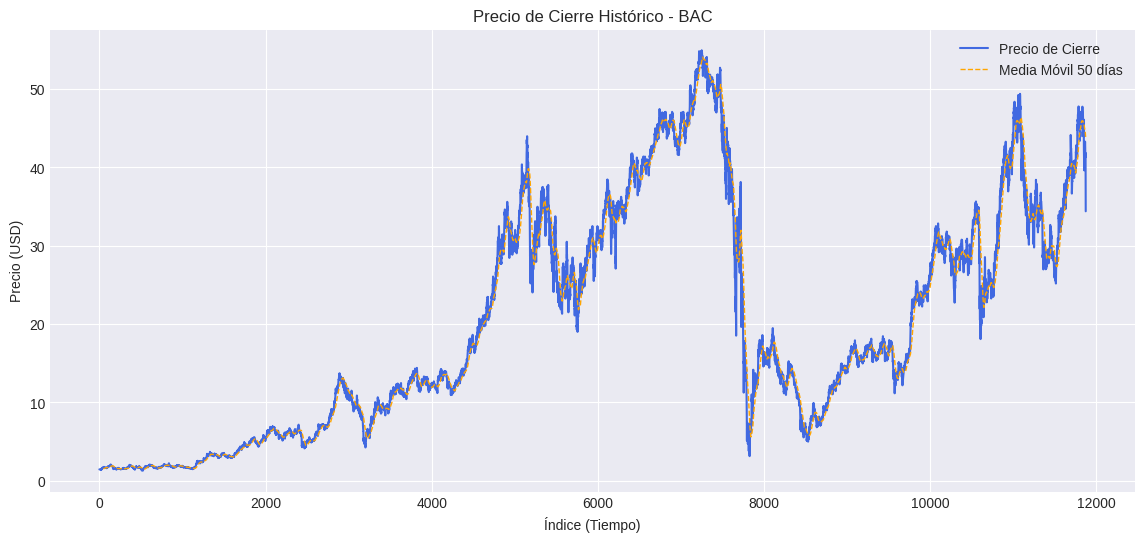

   Mostrando volumen diario.


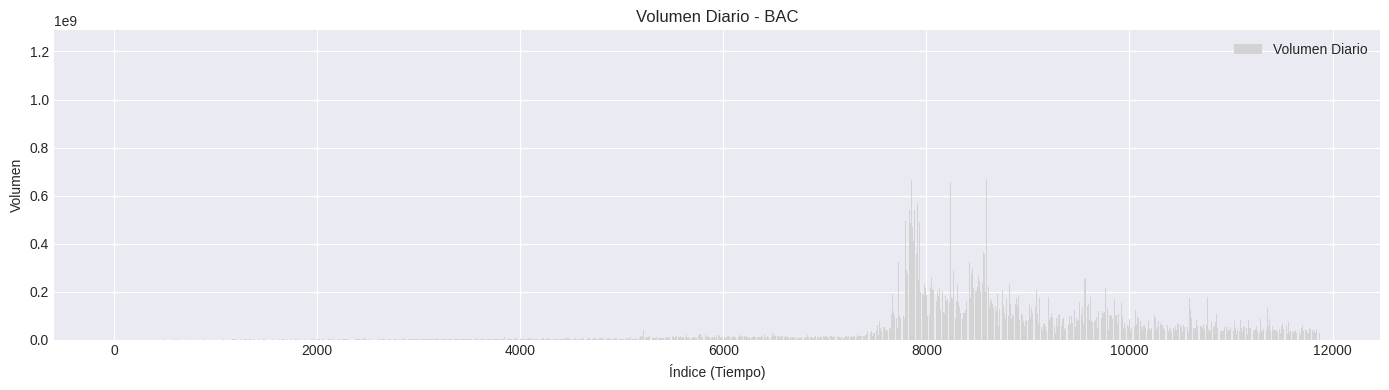


🏁 Análisis completado.


In [ ]:
# 📈 Proyecto Bank of America

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from contextlib import closing
from typing import Optional, List, Dict, Any, Tuple

# Asegurarse que las librerías de visualización están instaladas
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    print("⚠️ Advertencia: Matplotlib o Seaborn no están instalados.")
    print("Ejecuta: pip install matplotlib seaborn")
    # Puedes decidir si detener el script o continuar sin visualizaciones
    # exit() # Descomenta si quieres detener la ejecución

def load_and_clean_data(file_path: str) -> Optional[pd.DataFrame]:
    """
    Carga datos desde CSV, limpia nombres de columna y convierte fechas.

    Args:
        file_path: Ruta al archivo CSV.

    Returns:
        DataFrame limpio o None si hay error al cargar.
    """
    print(f"🔄 Cargando datos desde {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"❌ Error: Archivo no encontrado en {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error inesperado al cargar {file_path}: {e}")
        return None

    print("🔍 Columnas detectadas en el archivo:")
    print(list(df.columns)) # Mostrar como lista para claridad

    # Eliminar espacios y estandarizar a minúsculas.
    original_columns = list(df.columns)
    df.columns = [col.strip().lower() for col in df.columns]
    print("\n🧼 Columnas después de limpiar (minúsculas y sin espacios):")
    print(list(df.columns))

    # Renombrar columna de fecha.
    date_col_name = None
    possible_date_cols = ['date', 'fecha', 'timestamp'] # Añade otras variantes si es necesario
    for col in possible_date_cols:
        if col in df.columns:
            date_col_name = col
            break

    if date_col_name:
        print(f"\n🔄 Intentando convertir la columna '{date_col_name}' a formato fecha...")
        try:
            # Intentar convertir a datetime y luego a string YYYY-MM-DD
            df[date_col_name] = pd.to_datetime(df[date_col_name])
            df[date_col_name] = df[date_col_name].dt.strftime('%Y-%m-%d')
            print(f"✅ Columna '{date_col_name}' convertida a formato compatible con SQLite (YYYY-MM-DD).")
            # Renombrar a 'date' estándar si no lo es ya
            if date_col_name != 'date':
                 df.rename(columns={date_col_name: 'date'}, inplace=True)
                 print(f"   Columna renombrada a 'date'.")
        except Exception as e:
            print(f"\n⚠️ Error al convertir la columna '{date_col_name}': {e}")
            print("   Intentando mantenerla como string simple.")
            df[date_col_name] = df[date_col_name].astype(str)
            # Renombrar si es necesario
            if date_col_name != 'date':
                 df.rename(columns={date_col_name: 'date'}, inplace=True)
                 print(f"   Columna renombrada a 'date'.")
    else:
        print("\n⚠️ No se encontró una columna de fecha estándar ('date', 'fecha', etc.). Revisa el CSV.")
        # Podrías decidir detenerte aquí si la fecha es esencial
        # return None

    # Asegurar nombres de columnas estándar para el resto del script
    # (Asumiendo formato OHLCV: open, high, low, close, volume)
    expected_cols = {'open', 'high', 'low', 'close', 'volume'}
    if not expected_cols.issubset(df.columns):
         print(f"⚠️ Advertencia: Faltan columnas esperadas. Se detectaron: {list(df.columns)}")
         print(f"   Se esperaban: {list(expected_cols)}")

    return df


def create_database(df: pd.DataFrame, db_path: str, table_name: str) -> Optional[sqlite3.Connection]:
    """
    Crea una base de datos SQLite y carga el DataFrame en una tabla.

    Args:
        df: DataFrame a cargar.
        db_path: Ruta para la base de datos SQLite.
        table_name: Nombre para la tabla a crear.

    Returns:
        Conexión a la base de datos o None si hay error.
    """
    print(f"\n🗄️ Creando/Conectando a la base de datos: {db_path}")
    try:
        # Eliminar archivo de BD si existe para asegurar carga limpia (opcional)
        if os.path.exists(db_path):
            print(f"   Base de datos existente encontrada. Se reemplazará la tabla '{table_name}'.")
            # os.remove(db_path) # Descomenta si quieres empezar de cero siempre
        conn = sqlite3.connect(db_path)
        df.to_sql(table_name, conn, if_exists="replace", index=False)
        print(f"✅ Tabla '{table_name}' creada/reemplazada y cargada exitosamente.")
        return conn
    except sqlite3.Error as e:
        print(f"❌ Error de SQLite al crear/cargar la tabla: {e}")
        return None
    except Exception as e:
        print(f"❌ Error inesperado al interactuar con la base de datos: {e}")
        return None

def execute_query(conn: sqlite3.Connection, query: str, description: str = "") -> pd.DataFrame:
    """
    Ejecuta una consulta SQL y devuelve los resultados como DataFrame.

    Args:
        conn: Conexión a la base de datos.
        query: Consulta SQL a ejecutar.
        description: Descripción opcional de la consulta.

    Returns:
        Resultados de la consulta como DataFrame (vacío si hay error).
    """
    if description:
        print(f"\n### {description}")

    try:
        result_df = pd.read_sql_query(query, conn)
        print(f"📊 Resultados ({len(result_df)} filas):")
        # Mostrar solo las primeras filas si es muy grande
        print(result_df.head())
        if len(result_df) > 5:
            print("   ...")
        print("-" * 50)
        return result_df
    except sqlite3.Error as e:
        print(f"❌ Error de SQLite al ejecutar consulta: {e}")
        print(f"   Consulta problemática: {query}")
        return pd.DataFrame() # Devolver DataFrame vacío en caso de error
    except Exception as e:
        print(f"❌ Error inesperado al ejecutar consulta: {e}")
        return pd.DataFrame()

def run_basic_queries(conn: sqlite3.Connection, table_name: str) -> Dict[str, pd.DataFrame]:
    """
    Ejecuta consultas de análisis básicas sobre los datos de acciones.

    Args:
        conn: Conexión a la base de datos.
        table_name: Nombre de la tabla de acciones.

    Returns:
        Diccionario con los resultados de las consultas.
    """
    results = {}
    if not conn: return results # Si no hay conexión, no hacer nada

    # 1. Precio máximo y mínimo histórico
    query = f'''
    SELECT MAX(high) AS max_price, MIN(low) AS min_price
    FROM {table_name};
    '''
    results["max_min_price"] = execute_query(conn, query, "1. Precio máximo y mínimo histórico")

    # 2. Precio promedio por año
    query = f'''
    SELECT strftime('%Y', date) AS anio, ROUND(AVG(close), 2) AS promedio_cierre
    FROM {table_name}
    WHERE date IS NOT NULL AND date != '' -- Evitar errores si hay fechas nulas
    GROUP BY anio
    ORDER BY anio;
    '''
    results["yearly_avg"] = execute_query(conn, query, "2. Precio promedio por año")

    # 3. Volumen total de operaciones por año
    query = f'''
    SELECT strftime('%Y', date) AS anio, SUM(volume) AS volumen_total
    FROM {table_name}
    WHERE date IS NOT NULL AND date != ''
    GROUP BY anio
    ORDER BY anio;
    '''
    results["yearly_volume"] = execute_query(conn, query, "3. Volumen total de operaciones por año")

    # 4. Días con mayor volatilidad (rango high-low)
    query = f'''
    SELECT date, high, low, ROUND(high - low, 2) AS volatilidad
    FROM {table_name}
    WHERE high IS NOT NULL AND low IS NOT NULL -- Asegurar que los datos existen
    ORDER BY volatilidad DESC
    LIMIT 10;
    '''
    results["volatility"] = execute_query(conn, query, "4. Días con mayor volatilidad (Top 10)")

    # 5. Subconsulta: Días con cierre superior al promedio histórico general
    query = f'''
    SELECT date, close
    FROM {table_name}
    WHERE close > (SELECT AVG(close) FROM {table_name})
    ORDER BY date DESC -- Mostrar los más recientes primero
    LIMIT 20; -- Limitar resultados para no imprimir demasiado
    '''
    results["above_avg_recent"] = execute_query(conn, query, "5. Últimos 20 días con cierre superior al promedio histórico")

    return results

def run_advanced_queries(conn: sqlite3.Connection, table_name: str) -> Dict[str, pd.DataFrame]:
    """
    Ejecuta consultas de análisis avanzadas.

    Args:
        conn: Conexión a la base de datos.
        table_name: Nombre de la tabla de acciones.

    Returns:
        Diccionario con los resultados de las consultas.
    """
    results = {}
    if not conn: return results

    # 6. Precio promedio por mes
    query = f'''
    SELECT strftime('%Y-%m', date) AS mes, ROUND(AVG(close), 2) AS promedio_mensual
    FROM {table_name}
    WHERE date IS NOT NULL AND date != ''
    GROUP BY mes
    ORDER BY mes DESC -- Mostrar los más recientes primero
    LIMIT 12; -- Últimos 12 meses
    '''
    results["monthly_avg_recent"] = execute_query(conn, query, "6. Precio promedio por mes (Últimos 12)")

    # 7. Primer y último precio registrado
    query = f'''
    WITH ordered_prices AS (
        SELECT date, close, ROW_NUMBER() OVER (ORDER BY date ASC) as rn_asc,
               ROW_NUMBER() OVER (ORDER BY date DESC) as rn_desc
        FROM {table_name}
        WHERE date IS NOT NULL AND date != '' AND close IS NOT NULL
    )
    SELECT
      (SELECT close FROM ordered_prices WHERE rn_asc = 1) AS precio_inicial,
      (SELECT date FROM ordered_prices WHERE rn_asc = 1) AS fecha_inicial,
      (SELECT close FROM ordered_prices WHERE rn_desc = 1) AS precio_final,
      (SELECT date FROM ordered_prices WHERE rn_desc = 1) AS fecha_final;
    '''
    results["first_last"] = execute_query(conn, query, "7. Primer y último precio/fecha registrado")

    # 8. Evolución mensual (promedio) y comparación con mes anterior (LAG)
    query = f'''
    WITH precios_mensuales AS (
      SELECT strftime('%Y-%m', date) AS mes, ROUND(AVG(close), 2) AS cierre_prom_mes
      FROM {table_name}
      WHERE date IS NOT NULL AND date != ''
      GROUP BY mes
    )
    SELECT mes, cierre_prom_mes,
           LAG(cierre_prom_mes, 1, 0) OVER (ORDER BY mes) AS cierre_prom_prev, -- Usa 0 si no hay anterior
           ROUND(cierre_prom_mes - LAG(cierre_prom_mes, 1, cierre_prom_mes) OVER (ORDER BY mes), 2) AS variacion_abs,
           ROUND((cierre_prom_mes / LAG(cierre_prom_mes, 1, NULL) OVER (ORDER BY mes) - 1) * 100, 2) AS variacion_pct -- Evita división por cero
    FROM precios_mensuales
    ORDER BY mes DESC
    LIMIT 12; -- Últimos 12 meses
    '''
    results["monthly_evolution"] = execute_query(conn, query, "8. Evolución mensual y comparación con mes anterior (Últimos 12)")

    # 9. Ranking de años con mayor volumen promedio diario
    query = f'''
    SELECT strftime('%Y', date) AS anio, ROUND(AVG(volume), 0) AS volumen_prom_diario
    FROM {table_name}
    WHERE date IS NOT NULL AND date != '' AND volume IS NOT NULL
    GROUP BY anio
    ORDER BY volumen_prom_diario DESC
    LIMIT 5;
    '''
    results["volume_ranking_avg"] = execute_query(conn, query, "9. Ranking de años con mayor volumen promedio diario (Top 5)")

    # 10. Días con caída diaria mayor al 5% respecto al cierre anterior
    query = f'''
    WITH precios_diarios AS (
      SELECT date, close, LAG(close, 1, NULL) OVER (ORDER BY date) AS close_ant
      FROM {table_name}
      WHERE date IS NOT NULL AND date != '' AND close IS NOT NULL
    )
    SELECT date, close_ant, close,
           ROUND(((close / close_ant) - 1) * 100, 2) AS variacion_pct
    FROM precios_diarios
    WHERE close_ant IS NOT NULL AND close_ant != 0 AND ((close / close_ant) - 1) * 100 < -5.0
    ORDER BY date DESC
    LIMIT 10; -- Últimas 10 caídas fuertes
    '''
    results["big_drops_recent"] = execute_query(conn, query, "10. Días con caída > 5% (Últimos 10 eventos)")

    return results


def create_visualization(df: pd.DataFrame, ticker: str = "Activo") -> None:
    """
    Crea visualizaciones básicas del precio y volumen.
    Maneja correctamente los casos donde la conversión a DatetimeIndex falla.

    Args:
        df: DataFrame con los datos (requiere columnas 'close', 'volume', y preferiblemente 'date').
        ticker: Nombre del activo para los títulos de los gráficos.
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
    except ImportError:
        print("ℹ️ Visualizaciones omitidas porque matplotlib/seaborn no están instalados.")
        return

    if 'close' not in df.columns or 'volume' not in df.columns:
        print("⚠️ No se pueden crear visualizaciones: faltan columnas 'close' o 'volume'.")
        return

    df_plot = df.copy()
    is_datetime_index = False  # Flag para saber si tenemos un índice de fecha válido

    # Intentar convertir 'date' a DatetimeIndex
    if 'date' in df_plot.columns:
        print("\n🔄 Intentando configurar índice de fecha para visualización...")
        try:
            df_plot['date'] = pd.to_datetime(df_plot['date'])
            df_plot.set_index('date', inplace=True)
            is_datetime_index = isinstance(df_plot.index, pd.DatetimeIndex) # Doble chequeo
            if is_datetime_index:
                 print("✅ Índice DatetimeIndex configurado correctamente.")
            else:
                 # Esto no debería pasar si set_index tuvo éxito, pero por si acaso
                 print("⚠️ El índice no es DatetimeIndex después de set_index.")

        except Exception as e:
            print(f"⚠️ Error al convertir 'date' a DatetimeIndex: {e}.")
            print("   Se continuará usando el índice por defecto (numérico).")
            # is_datetime_index permanece False
            # Asegurarse que 'date' (si existe) no cause problemas más adelante si no es el índice
            if 'date' in df_plot.columns and df_plot.index.name == 'date':
                 df_plot.reset_index(inplace=True) # Quitar índice si se llama 'date' pero falló

    elif isinstance(df_plot.index, pd.DatetimeIndex):
         # Si 'date' no estaba como columna, pero el índice YA ERA datetime
         print("ℹ️ Usando el índice DatetimeIndex existente.")
         is_datetime_index = True
    else:
         print("⚠️ No se encontró columna 'date' y el índice no es DatetimeIndex. Se usará índice numérico.")


    print(f"\n📊 Generando visualizaciones para {ticker}...")
    plt.style.use('seaborn-v0_8-darkgrid')

    # --- Gráfico de precios de cierre ---
    plt.figure(figsize=(14, 6))
    # El índice a usar para el eje X depende de si logramos crear el DatetimeIndex
    x_axis = df_plot.index if is_datetime_index else pd.RangeIndex(start=0, stop=len(df_plot))
    x_label = 'Fecha' if is_datetime_index else 'Índice (Tiempo)'

    try:
        plt.plot(x_axis, df_plot['close'], label='Precio de Cierre', color='royalblue', linewidth=1.5)
        if 'ma50' in df_plot.columns:
            # Asegurarse que MA50 tenga la misma longitud que el eje X
            ma50_values = df_plot['ma50'].values[:len(x_axis)] if len(df_plot['ma50']) > len(x_axis) else df_plot['ma50']
            plt.plot(x_axis, ma50_values, label='Media Móvil 50 días', color='orange', linestyle='--', linewidth=1)

        plt.title(f'Precio de Cierre Histórico - {ticker}')
        plt.xlabel(x_label)
        plt.ylabel('Precio (USD)')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"❌ Error al generar gráfico de precios: {e}")


    # --- Gráfico de volumen ---
    plt.figure(figsize=(14, 4)) # Tamaño por defecto

    # Intentar agrupar por año SOLO si tenemos DatetimeIndex y suficientes datos
    if is_datetime_index and len(df_plot) > 365 * 2:
        print("   Intentando agrupar volumen por año...")
        try:
            # --- ¡AHORA ESTA LÍNEA ES SEGURA! ---
            df_plot['year'] = df_plot.index.year
            volumen_agrupado = df_plot.groupby('year')['volume'].sum()

            # Graficar volumen anual si la agrupación funcionó
            plt.figure(figsize=(12, 5)) # Reajustar tamaño para barplot anual
            sns.barplot(x=volumen_agrupado.index, y=volumen_agrupado.values, palette='viridis')
            plt.title(f'Volumen Total de Transacciones por Año - {ticker}')
            plt.xlabel('Año')
            plt.ylabel('Volumen Total')
            plt.xticks(rotation=45)
            print("   Gráfico de volumen anual generado.")

        except Exception as e:
            # Fallback a volumen diario si la agrupación por año falla por alguna razón
            print(f"   ⚠️ Error al agrupar/graficar volumen anual: {e}. Mostrando volumen diario.")
            plt.bar(x_axis, df_plot['volume'], label='Volumen Diario', color='lightgray')
            plt.title(f'Volumen Diario - {ticker}')
            plt.xlabel(x_label)
            plt.ylabel('Volumen')
            plt.legend()

    else:
        # Mostrar volumen diario si no hay DatetimeIndex o si hay pocos datos
        print("   Mostrando volumen diario.")
        try:
            plt.bar(x_axis, df_plot['volume'], label='Volumen Diario', color='lightgray')
            plt.title(f'Volumen Diario - {ticker}')
            plt.xlabel(x_label)
            plt.ylabel('Volumen')
            plt.legend()
        except Exception as e:
            print(f"❌ Error al generar gráfico de volumen diario: {e}")


    plt.tight_layout() # Ajustar espaciado
    plt.show() # Mostrar el gráfico de volumen

def calcular_indicadores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula indicadores técnicos básicos (MA50, RSI).

    Args:
        df: DataFrame con columna 'close'.

    Returns:
        DataFrame original con las nuevas columnas de indicadores.
    """
    if 'close' not in df.columns:
        print("⚠️ No se puede calcular indicadores: falta la columna 'close'.")
        return df

    print("\n⚙️ Calculando indicadores técnicos (MA50, RSI)...")
    df_out = df.copy()

    # Media Móvil Simple de 50 días
    df_out['ma50'] = df_out['close'].rolling(window=50).mean()

    # RSI (Relative Strength Index) de 14 días
    delta = df_out['close'].diff()
    gain = delta.where(delta > 0, 0.0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0.0).rolling(window=14).mean()

    # Evitar división por cero en RS
    rs = gain / loss.replace(0, 0.000001) # Reemplazar 0 en loss con un valor muy pequeño

    df_out['rsi'] = 100 - (100 / (1 + rs))
    # Rellenar NaNs iniciales del RSI si se desea (opcional)
    # df_out['rsi'].fillna(50, inplace=True) # Podría rellenarse con 50 (neutral)

    print("✅ Indicadores calculados.")
    return df_out

def exportar_resultados(results: Dict[str, pd.DataFrame], output_dir: str = "resultados_analisis") -> None:
    """
    Exporta los DataFrames de resultados a archivos CSV y Excel.

    Args:
        results: Diccionario donde las claves son nombres de archivo y los valores son DataFrames.
        output_dir: Directorio donde se guardarán los archivos.
    """
    if not results:
        print("ℹ️ No hay resultados para exportar.")
        return

    print(f"\n📤 Exportando resultados a la carpeta: '{output_dir}'...")
    try:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"   Directorio '{output_dir}' creado.")

        export_count = 0
        for name, df in results.items():
            if isinstance(df, pd.DataFrame) and not df.empty:
                try:
                    # Sanitizar nombre para archivo
                    safe_name = "".join(c for c in name if c.isalnum() or c in ('_', '-')).rstrip()
                    path_csv = os.path.join(output_dir, f"{safe_name}.csv")
                    path_excel = os.path.join(output_dir, f"{safe_name}.xlsx")

                    df.to_csv(path_csv, index=False, encoding='utf-8-sig') # utf-8-sig para compatibilidad Excel
                    df.to_excel(path_excel, index=False)
                    export_count += 1
                except Exception as e:
                    print(f"   ⚠️ Error al exportar '{name}': {e}")
            else:
                print(f"   ℹ️ Omitiendo exportación para '{name}' (no es un DataFrame válido o está vacío).")

        print(f"✅ {export_count} resultados exportados exitosamente a CSV y Excel.")

    except OSError as e:
        print(f"❌ Error de sistema al crear/escribir en el directorio '{output_dir}': {e}")
    except Exception as e:
        print(f"❌ Error inesperado durante la exportación: {e}")


def main() -> None:
    """Función principal para orquestar el análisis."""

    CONFIG = {
        "csv_path": "BAC.csv",      # Asegúrate que este archivo existe en el mismo directorio o proporciona la ruta completa
        "db_path": "stocks_bac.db",
        "table_name": "stocks_bac",
        "output_dir": "resultados_bac" # Directorio para guardar CSV/Excel
    }
    TICKER_SYMBOL = "BAC" # Para títulos en gráficos

    # 1. Cargar y limpiar datos
    df_original = load_and_clean_data(CONFIG["csv_path"])

    if df_original is None:
        print("\n❌ Proceso detenido: No se pudieron cargar los datos.")
        return # Salir si no hay datos

    # Mostrar una vista previa de los datos limpios
    print("\n📊 Vista previa de los datos limpios:")
    print(df_original.head())
    print("\nℹ️ Información del DataFrame:")
    df_original.info() # Da un resumen de tipos de datos y nulos

    # 2. Calcular Indicadores (sobre el df limpio antes de guardar en DB si quieres usarlos luego)
    df_con_indicadores = calcular_indicadores(df_original)
    print("\n📊 Vista previa con indicadores (MA50, RSI):")
    print(df_con_indicadores.tail()) # Mostrar las últimas filas donde los indicadores ya no son NaN

    # 3. Crear base de datos y cargar datos (usaremos el df original sin indicadores en la BD)
    #    Usamos 'closing' para asegurar que la conexión se cierre incluso si hay errores
    conn = None # Inicializar conn fuera del try
    try:
        with closing(create_database(df_original, CONFIG["db_path"], CONFIG["table_name"])) as conn:

            if conn: # Proceder solo si la conexión fue exitosa
                # 4. Ejecutar consultas
                print("\n🔍 EJECUTANDO CONSULTAS BÁSICAS...")
                basic_results = run_basic_queries(conn, CONFIG["table_name"])

                print("\n🧠 EJECUTANDO CONSULTAS AVANZADAS...")
                advanced_results = run_advanced_queries(conn, CONFIG["table_name"])

                # Combinar todos los resultados para exportar
                all_results = {**basic_results, **advanced_results}

                # 5. Exportar resultados de las consultas
                exportar_resultados(all_results, CONFIG["output_dir"])

            else:
                print("\n⚠️ No se pudo establecer conexión con la base de datos. Consultas y exportación omitidas.")

    except Exception as e:
        print(f"\n❌ Error durante la fase de base de datos o consultas: {e}")
    # La conexión se cierra automáticamente aquí por el 'with closing()'

    # 6. Crear Visualizaciones (usando el df con indicadores)
    #    *** CORRECCIÓN AQUÍ ***: Pasar un título descriptivo, no el tipo 'str'
    create_visualization(df_con_indicadores, ticker=TICKER_SYMBOL)

    print("\n🏁 Análisis completado.")


# Punto de entrada del script
if __name__ == "__main__":
    # *** CORRECCIÓN AQUÍ ***: main() no devuelve nada útil para asignar, solo ejecuta.
    main()